# Rendimiento de vehículos híbridos enchufables

El objetivo del análisis de este dataset es establecer una comparativa entre el rendimiento de distintos vehículos híbridos enchufables y determinar, de manera preliminar, cuál es el que mejor se adapta a los requerimientos del proyecto.


# ETL

In [55]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, HTML
display(HTML("<style>div.output_scroll { height: auto !important; max-height: none !important; }</style>"))
import seaborn as sns


In [56]:
rutas = '../Variables_entorno/rutas.txt'

In [57]:
with open(rutas, 'r') as archivo:
    for linea in archivo.readlines():
        exec(linea.strip(), globals())

In [58]:
df = pd.read_csv(rendimiento_hibrido_enchufable, encoding='utf-8')

In [59]:
df.columns

Index(['_id', 'Model year', 'Make', 'Model', 'Vehicle class', 'Motor (kW)',
       'Engine size (L)', 'Cylinders', 'Transmission', 'Fuel type 1',
       'Combined Le/100 km', 'Range 1 (km)', 'Recharge time (h)',
       'Fuel type 2', 'City (L/100 km)', 'Highway (L/100 km)',
       'Combined (L/100 km)', 'Range 2 (km)', 'CO2 emissions (g/km)',
       'CO2 rating', 'Smog rating'],
      dtype='object')

Analizando el diccionario de datos, decidimos borrar las columnas que no son de interés para nuestro análisis.

In [60]:
columnas_a_borrar = ['_id', 'Motor (kW)', 'Engine size (L)', 'Cylinders', 'Transmission', 'Fuel type 1', 'Fuel type 2',
                     'CO2 rating', 'Smog rating']

In [61]:
df = df.drop(columnas_a_borrar, axis=1)

### Verificamos tipo de dato de cada columna:

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293 entries, 0 to 292
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Model year            293 non-null    int64  
 1   Make                  293 non-null    object 
 2   Model                 293 non-null    object 
 3   Vehicle class         293 non-null    object 
 4   Combined Le/100 km    293 non-null    object 
 5   Range 1 (km)          293 non-null    int64  
 6   Recharge time (h)     293 non-null    float64
 7   City (L/100 km)       293 non-null    float64
 8   Highway (L/100 km)    293 non-null    float64
 9   Combined (L/100 km)   293 non-null    float64
 10  Range 2 (km)          293 non-null    int64  
 11  CO2 emissions (g/km)  293 non-null    int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 27.6+ KB


### Convesión de unidades unidades

Para normalizar los datos y que sean equivalentes con los de los otros datasets, convertimos los valores expresados en kilómetros a millas.

La columna 'Combined Le/100 km) es el índice de consumo combinado de combustible para funcionamiento en modo eléctrico, expresado en litros de gasolina equivalente cada 100 kilómetros. Entre paréntesis se muestra el consumo de electricidad en kilovatios hora cada 100 kilómetros y el consumo de gasolina (cuando corresponda) en litros cada 100 kilómetros.

La calificación combinada refleja un 55% de conducción en ciudad y un 45% de conducción en carretera. Un litro de gasolina contiene la energía equivalente a 8,9 kWh de electricidad.

Para la transformación de esta columna vamos a pasarlo a millas y devolver una tupla que indique litros equivalentes (le), KWh/100 m, litros/100 m.

Cuanto más bajo sean los valores, más eficiente es el vehículo.

In [63]:
def tupla(valor:str) -> tuple:
    valor_nuevo = ''
    for caracter in valor:
        if caracter.isnumeric() or caracter == '.' or caracter == ' ':
            valor_nuevo += caracter
        else:
            continue
    valor_nuevo = valor_nuevo.split()
    lista = []
    for numero in valor_nuevo[:-1]:
        lista.append(round(float(numero)*1.609,2))
    if '+' in valor:
        tupla = tuple(lista)
    else:
        lista.append(0)
        tupla = tuple(lista)
    #print(valor)
    return (tupla)



In [64]:
df = df.rename(columns={'Combined Le/100 km': 'Combined le/100 miles'})

In [65]:
df['Combined le/100 miles'] = df['Combined le/100 miles'].apply(tupla)

In [66]:
df['EM le/100 miles'] = df['Combined le/100 miles'].apply(lambda x: x[0] if isinstance(x, tuple) else None)
df['EM KWh/100 miles'] = df['Combined le/100 miles'].apply(lambda x: x[1] if isinstance(x, tuple) else None)
df['EM aditional fuel l/100 miles'] = df['Combined le/100 miles'].apply(lambda x: x[2] if isinstance(x, tuple) else None)

In [67]:
df = df.drop('Combined le/100 miles', axis=1)

In [68]:
df = df.rename(columns={'Range 1 (km)': 'Range 1 (miles)'})

In [69]:
df['Range 1 (miles)'] = round(df['Range 1 (miles)']/1.609,2)

In [70]:
df = df.rename(columns={'City (L/100 km)': 'City (l/100 miles)'})

In [71]:
df['City (l/100 miles)'] = round(df['City (l/100 miles)']*1.609,2)

In [72]:
df = df.rename(columns={'Highway (L/100 km)': 'Highway (l/100 miles)'})

In [73]:
df['Highway (l/100 miles)'] = round(df['Highway (l/100 miles)']*1.609,2)

In [74]:
df = df.rename(columns={'Combined (L/100 km)': 'Combined (l/100 miles)'})

In [75]:
df['Combined (l/100 miles)'] = round(df['Combined (l/100 miles)']*1.609,2)

In [76]:
df = df.rename(columns={'Range 2 (km)': 'Range 2 (miles)'})

In [77]:
df['Range 2 (miles)'] = round(df['Range 2 (miles)']/1.609,2)

In [78]:
df = df.rename(columns={'CO2 emissions (g/km)': 'CO2 emissions (g/miles)'})

In [79]:
df['CO2 emissions (g/miles)'] = round(df['CO2 emissions (g/miles)']*1.609,2)

Filtramos el df por clases de vehículos y por años, que es lo que nos interesa para el análisis.

In [80]:
categorias = ['Mid-size', 'Sport utility vehicle: Small',  'Full-size',
       'Sport utility vehicle: Standard', 'Minivan',
       'Station wagon: Small']

In [81]:
df = df[(df['Model year'] >= 2022) & (df['Vehicle class'].isin(categorias))]

In [82]:
df.shape

(99, 14)

# EDA

Luego de la transformación de datos, vamos a verificar nulos, duplicados y outliers. Después vamos a buscar insights o datos relevantes sobre el tema que nos compete.

### Verificamos nulos:

In [83]:
for columna in df.columns:
    print(f'Columna: {columna} Nulos: {df[columna].isnull().sum()}')

Columna: Model year Nulos: 0
Columna: Make Nulos: 0
Columna: Model Nulos: 0
Columna: Vehicle class Nulos: 0
Columna: Range 1 (miles) Nulos: 0
Columna: Recharge time (h) Nulos: 0
Columna: City (l/100 miles) Nulos: 0
Columna: Highway (l/100 miles) Nulos: 0
Columna: Combined (l/100 miles) Nulos: 0
Columna: Range 2 (miles) Nulos: 0
Columna: CO2 emissions (g/miles) Nulos: 0
Columna: EM le/100 miles Nulos: 0
Columna: EM KWh/100 miles Nulos: 0
Columna: EM aditional fuel l/100 miles Nulos: 0


### Duplicados:

In [84]:
f'Cantidad de duplicados: {df.duplicated().sum()}'

'Cantidad de duplicados: 0'

### Outliers:


Columna: Recharge time (h)   

Modal: 3.0                      Promedio: 3.53                     Mediana: 3.0                     

Límite inferior: 0.75           Límite superior: 6.75              Outliers: 3               




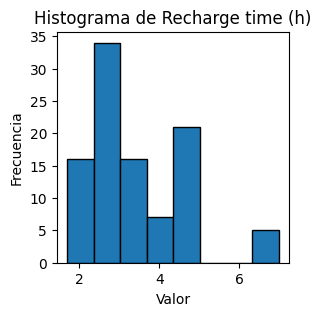

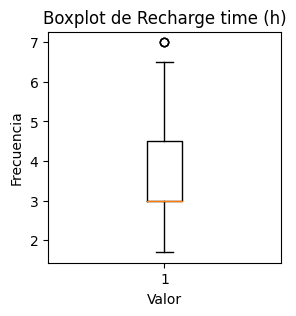







Columna: City (l/100 miles)  

Modal: 12.87, 13.68             Promedio: 14.5                     Mediana: 13.68                   

Límite inferior: 0.64           Límite superior: 27.68             Outliers: 3               




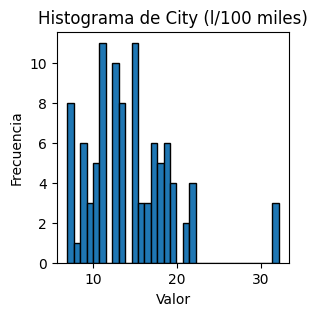

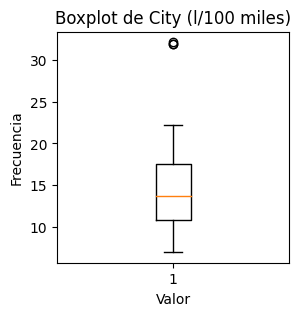







Columna: Highway (l/100 miles)

Modal: 13.84, 14.0              Promedio: 13.23                    Mediana: 13.03                   

Límite inferior: 6.19           Límite superior: 19.71             Outliers: 3               




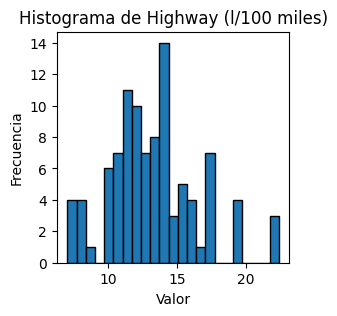

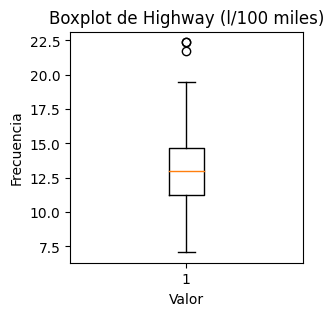







Columna: Combined (l/100 miles)

Modal: 10.78                    Promedio: 13.93                    Mediana: 13.68                   

Límite inferior: 2.81           Límite superior: 24.06             Outliers: 3               




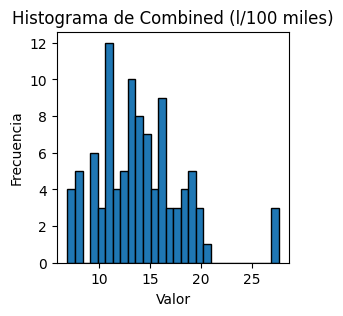

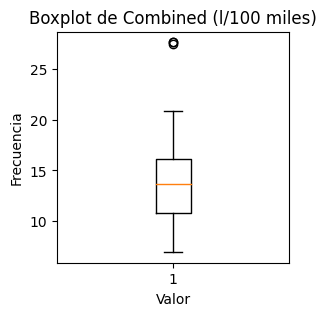







Columna: Range 2 (miles)     

Modal: 389.06                   Promedio: 430.97                   Mediana: 426.97                  

Límite inferior: 241.76         Límite superior: 634.56            Outliers: 0               




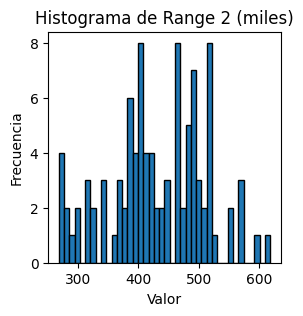

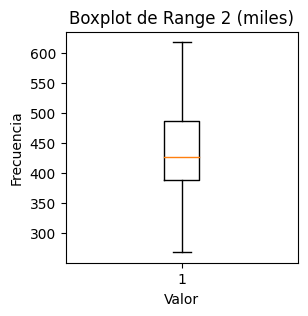







Columna: CO2 emissions (g/miles)

Modal: 104.58                   Promedio: 144.4                    Mediana: 120.68                  

Límite inferior: 0              Límite superior: 345.12            Outliers: 0               




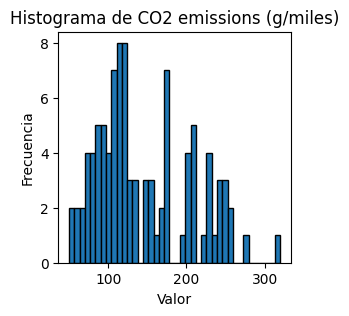

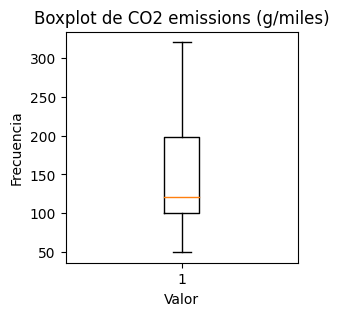







Columna: EM le/100 miles     

Modal: 4.83, 6.28, 6.76, 8.21   Promedio: 5.66                     Mediana: 5.47                    

Límite inferior: 1.54           Límite superior: 9.9               Outliers: 0               




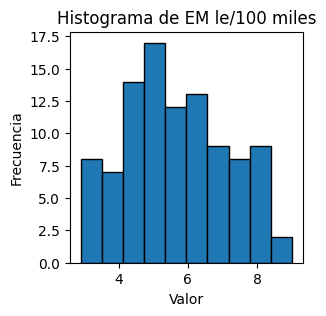

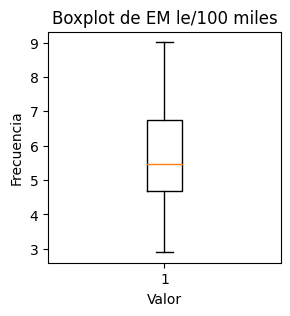







Columna: EM KWh/100 miles    

Modal: 43.76                    Promedio: 50.04                    Mediana: 48.27                   

Límite inferior: 16.89          Límite superior: 82.54             Outliers: 0               




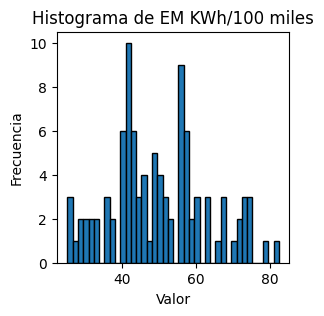

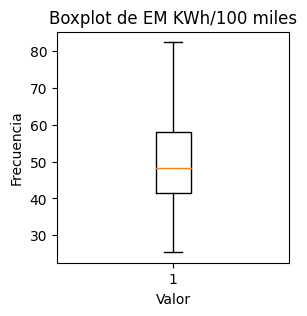







Columna: EM aditional fuel l/100 miles

Modal: 0.0                      Promedio: 0.02                     Mediana: 0.0                     

Límite inferior: 0.0            Límite superior: 0.0               Outliers: 3               




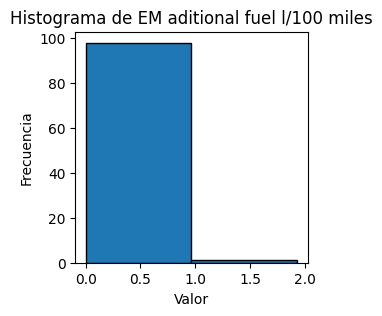

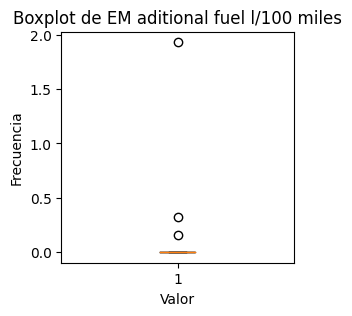

In [85]:
columnas_outliers = []
for columna in df.columns[5:]:
    q1 = df[columna].quantile(0.25)
    q3 = df[columna].quantile(0.75)
    iqr = q3 - q1
    modal = ''
    for valor in df[columna].mode().to_list():
        modal += str(valor) + ', '
    modal = modal[:-2]
    promedio = round(df[columna].mean(), 2)
    mediana = round(df[columna].median(), 2)
    limite_superior = round(q3 + 1.5 * iqr, 2)
    limite_inferior = round(q1 - 1.5 * iqr, 2)
    if limite_inferior < 0:
        limite_inferior = 0
    outliers = df[columna][(df[columna] > limite_superior) | (df[columna] < limite_inferior)].count()
    if outliers > 0:
        columnas_outliers.append({'Columna': columna, 'Cantidad de outliers': outliers,
                                  'Límite inferior': limite_inferior, 'Límite superior': limite_superior,
                                  'Índices': df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)].index.to_list()})
    print(f'\nColumna: {columna:<20}\n\nModal: {modal:<24} Promedio: {promedio:<24} Mediana: {mediana:<24}\n\nLímite inferior: {limite_inferior:<14} Límite superior: {limite_superior:<17} Outliers: {outliers:<16}\n\n')
    bins = (int(df[columna].max() +1) if df[columna].max() <= 40 else 40)
    plt.figure(figsize=(3,3))
    plt.hist(df[columna], bins=bins, edgecolor='black')
    plt.title(f'Histograma de {columna}')
    plt.xlabel('Valor')
    plt.ylabel('Frecuencia')
    plt.show()
    print('\n\n')
    plt.figure(figsize=(3,3))
    plt.boxplot(df[columna])
    plt.title(f'Boxplot de {columna}')
    plt.xlabel('Valor')
    plt.ylabel('Frecuencia')
    plt.show()
    print('\n\n\n\n')

### Revisión de outliers:

Vemos que hay algunos outliers, por lo que vamos a revisarlos.

In [86]:
columnas_outliers

[{'Columna': 'Recharge time (h)',
  'Cantidad de outliers': 3,
  'Límite inferior': 0.75,
  'Límite superior': 6.75,
  'Índices': [226, 260, 261]},
 {'Columna': 'City (l/100 miles)',
  'Cantidad de outliers': 3,
  'Límite inferior': 0.64,
  'Límite superior': 27.68,
  'Índices': [226, 260, 261]},
 {'Columna': 'Highway (l/100 miles)',
  'Cantidad de outliers': 3,
  'Límite inferior': 6.19,
  'Límite superior': 19.71,
  'Índices': [226, 260, 261]},
 {'Columna': 'Combined (l/100 miles)',
  'Cantidad de outliers': 3,
  'Límite inferior': 2.81,
  'Límite superior': 24.06,
  'Índices': [226, 260, 261]},
 {'Columna': 'EM aditional fuel l/100 miles',
  'Cantidad de outliers': 3,
  'Límite inferior': 0.0,
  'Límite superior': 0.0,
  'Índices': [239, 257, 281]}]

Vemos que para varias columnas se repiten los índices 226, 260, 261, por lo que vamos a revisarlos.

In [87]:
df.loc[[226, 260, 261]]

,Model year,Make,Model,Vehicle class,Range 1 (miles),Recharge time (h),City (l/100 miles),Highway (l/100 miles),Combined (l/100 miles),Range 2 (miles),CO2 emissions (g/miles),EM le/100 miles,EM KWh/100 miles,EM aditional fuel l/100 miles
226,2023,BMW,XM,Sport utility vehicle: Standard,31.08,7.0,32.02,22.37,27.67,267.87,244.57,8.21,73.21,0.0
260,2024,BMW,XM,Sport utility vehicle: Standard,31.08,7.0,32.02,22.37,27.67,267.87,244.57,8.21,73.21,0.0
261,2024,BMW,XM Label Red,Sport utility vehicle: Standard,31.08,7.0,32.18,21.72,27.51,270.98,255.83,8.21,73.21,0.0


Podemos observar que, comparado con otros vehículos, su eficiencia no es muy alta. Sin embargo, los valores no son erróneos, por lo que no borramos estos registros.

Verificamos la última columna con outliers, que se refiere a la cantidad de combustible utilizado cuando el vehículo está en modo eléctrico cada 100 millas.

In [88]:
columnas_outliers[-1]

{'Columna': 'EM aditional fuel l/100 miles',
 'Cantidad de outliers': 3,
 'Límite inferior': 0.0,
 'Límite superior': 0.0,
 'Índices': [239, 257, 281]}

In [89]:
df.loc[[239, 257, 281]]

,Model year,Make,Model,Vehicle class,Range 1 (miles),Recharge time (h),City (l/100 miles),Highway (l/100 miles),Combined (l/100 miles),Range 2 (miles),CO2 emissions (g/miles),EM le/100 miles,EM KWh/100 miles,EM aditional fuel l/100 miles
239,2023,Mercedes-Benz,S 580e 4MATIC Sedan,Full-size,55.94,2.25,18.50,13.19,16.09,417.03,107.80,7.40,48.91,1.93
257,2024,BMW,750e xDrive Sedan,Full-size,34.18,5.00,15.93,14.16,15.12,431.95,131.94,5.79,50.04,0.16
281,2024,Mazda,CX-90 PHEV 4WD,Sport utility vehicle: Standard,26.10,2.10,15.93,14.00,15.12,464.26,168.94,6.76,57.92,0.32


Vemos que son vehículos grandes y utilitarios, pero tampoco son valores erróneos, por lo que no borramos los registros.

# Análisis de datos

In [90]:
df.shape

(99, 14)

In [91]:
df.head()

,Model year,Make,Model,Vehicle class,Range 1 (miles),Recharge time (h),City (l/100 miles),Highway (l/100 miles),Combined (l/100 miles),Range 2 (miles),CO2 emissions (g/miles),EM le/100 miles,EM KWh/100 miles,EM aditional fuel l/100 miles
177,2022,Audi,A7 Sportback 55 TFSI e quattro,Mid-size,26.10,3.0,15.29,12.07,13.84,387.20,125.50,5.47,48.11,0.0
178,2022,Audi,Q5 55 TFSI e quattro,Sport utility vehicle: Small,23.00,3.0,15.12,14.16,14.64,369.17,148.03,6.28,55.83,0.0
179,2022,Bentley,Flying Spur Hybrid,Mid-size,21.13,3.0,22.04,17.22,19.79,405.84,251.00,8.21,73.85,0.0
182,2022,BMW,530e xDrive,Mid-size,19.27,3.0,16.89,13.52,15.29,302.05,202.73,6.11,52.94,0.0
183,2022,BMW,745Le xDrive,Full-size,16.78,3.0,19.63,14.64,17.38,270.35,244.57,6.76,60.18,0.0


Para determinar la eficiencia del vehículo, primero vamos a crear una columna que indique el rango total (batería totalmente cargada + tanque totalmente lleno). Este rango no es totalmente exacto y depende de cada vehículo, ya que nunca se agota el total de la carga. Vamos a tomar un coeficiente basándonos en un promedio general.

In [92]:
df['Total range (miles)'] = round(df['Range 1 (miles)']*.8 + df['Range 2 (miles)'],2)

Agregamos una columna con la cantidad de millas recorridas con una hora de carga (solo en modo eléctrico).

In [93]:
df['Miles per charging hour'] = round(df['Range 1 (miles)'] / df['Recharge time (h)'],2)

### Top 10 de vehículos con mayor autonomía total

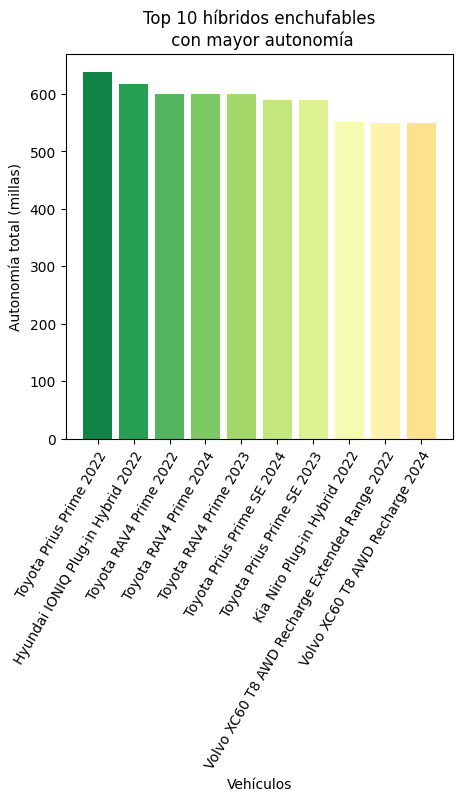

In [94]:
marca = df.sort_values(by='Total range (miles)', ascending=False).head(10)['Make'].to_list()
modelo = df.sort_values(by='Total range (miles)', ascending=False).head(10)['Model'].to_list()
año = df.sort_values(by='Total range (miles)', ascending=False).head(10)['Model year'].to_list()
autonomia = df.sort_values(by='Total range (miles)', ascending=False).head(10)['Total range (miles)'].to_list()
vehiculos = []
for i in range(10):
    vehiculo = f'{marca[i]} {modelo[i]} {str(año[i])}'
    vehiculos.append(vehiculo)
plt.figure(figsize=(5,5))
plt.bar(vehiculos, autonomia, color=plt.cm.RdYlGn_r([i/16.8 for i in range(1,11)]))
plt.xlabel('Vehículos')
plt.ylabel('Autonomía total (millas)')
plt.title('Top 10 híbridos enchufables\n con mayor autonomía')
plt.xticks(rotation=60, ha='right', rotation_mode='anchor')
plt.show()

### Top 5 de vehículos con mayor autonomía en modo eléctrico

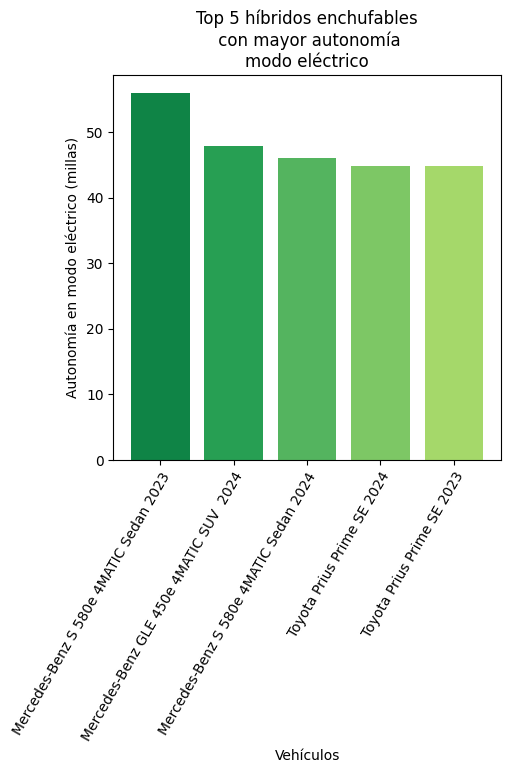

In [95]:
marca = df.sort_values(by='Range 1 (miles)', ascending=False).head(5)['Make'].to_list()
modelo = df.sort_values(by='Range 1 (miles)', ascending=False).head(5)['Model'].to_list()
año = df.sort_values(by='Range 1 (miles)', ascending=False).head(5)['Model year'].to_list()
autonomia = df.sort_values(by='Range 1 (miles)', ascending=False).head(5)['Range 1 (miles)'].to_list()
vehiculos = []
for i in range(5):
    vehiculo = f'{marca[i]} {modelo[i]} {str(año[i])}'
    vehiculos.append(vehiculo)
plt.figure(figsize=(5,5))
plt.bar(vehiculos, autonomia, color=plt.cm.RdYlGn_r([i/16.8 for i in range(1,6)]))
plt.xlabel('Vehículos')
plt.ylabel('Autonomía en modo eléctrico (millas)')
plt.title('Top 5 híbridos enchufables\n con mayor autonomía\nmodo eléctrico')
plt.xticks(rotation=60, ha='right', rotation_mode='anchor')
plt.show()

Top 5 de vehículos con mayor rendimiento en ciudad

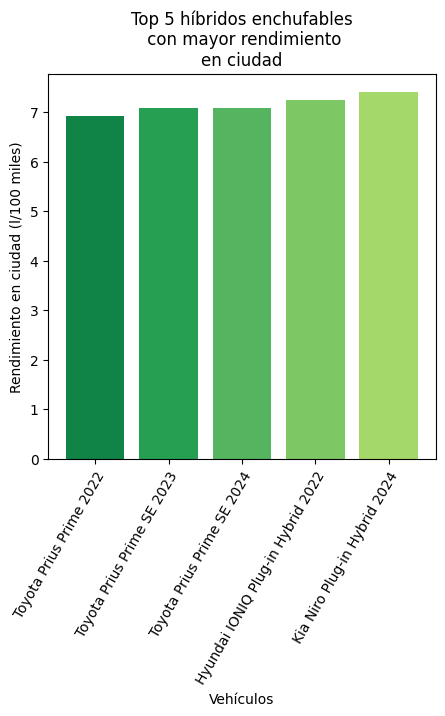

In [96]:
marca = df.sort_values(by='City (l/100 miles)').head(5)['Make'].to_list()
modelo = df.sort_values(by='City (l/100 miles)').head(5)['Model'].to_list()
año = df.sort_values(by='City (l/100 miles)').head(5)['Model year'].to_list()
rendimiento = df.sort_values(by='City (l/100 miles)').head(5)['City (l/100 miles)'].to_list()
vehiculos = []
for i in range(5):
    vehiculo = f'{marca[i]} {modelo[i]} {str(año[i])}'
    vehiculos.append(vehiculo)
plt.figure(figsize=(5,5))
plt.bar(vehiculos, rendimiento, color=plt.cm.RdYlGn_r([i/16.8 for i in range(1,6)]))
plt.xlabel('Vehículos')
plt.ylabel('Rendimiento en ciudad (l/100 miles)')
plt.title('Top 5 híbridos enchufables\n con mayor rendimiento\nen ciudad')
plt.xticks(rotation=60, ha='right', rotation_mode='anchor')
plt.show()

## Matriz de correlación:

In [97]:
matriz = df.corr()

In [98]:
matriz

,Model year,Range 1 (miles),Recharge time (h),City (l/100 miles),Highway (l/100 miles),Combined (l/100 miles),Range 2 (miles),CO2 emissions (g/miles),EM le/100 miles,EM KWh/100 miles,EM aditional fuel l/100 miles,Total range (miles),Miles per charging hour
Model year,1.000000,0.370464,0.162248,0.020676,0.006698,0.018644,-0.044200,-0.204779,-0.031381,-0.036402,0.037257,-0.011308,0.197762
Range 1 (miles),0.370464,1.000000,0.361665,-0.371489,-0.407763,-0.386779,0.438101,-0.764103,-0.466693,-0.506054,0.295390,0.504772,0.512845
Recharge time (h),0.162248,0.361665,1.000000,0.284573,0.261969,0.282184,-0.016316,-0.038726,0.110143,0.128268,-0.114887,0.014732,-0.544362
City (l/100 miles),0.020676,-0.371489,0.284573,1.000000,0.939910,0.992973,-0.627138,0.841833,0.910140,0.908745,0.085619,-0.633481,-0.393489
Highway (l/100 miles),0.006698,-0.407763,0.261969,0.939910,1.000000,0.973513,-0.604939,0.853403,0.930120,0.935045,0.005020,-0.615211,-0.436729
Combined (l/100 miles),0.018644,-0.386779,0.282184,0.992973,0.973513,1.000000,-0.627452,0.855972,0.928902,0.929686,0.059014,-0.635067,-0.412322
Range 2 (miles),-0.044200,0.438101,-0.016316,-0.627138,-0.604939,-0.627452,1.000000,-0.602324,-0.549990,-0.545885,-0.010440,0.997141,0.241236
CO2 emissions (g/miles),-0.204779,-0.764103,-0.038726,0.841833,0.853403,0.855972,-0.602324,1.000000,0.881337,0.896891,-0.054650,-0.642652,-0.521556
EM le/100 miles,-0.031381,-0.466693,0.110143,0.910140,0.930120,0.928902,-0.549990,0.881337,1.000000,0.990351,0.128878,-0.567395,-0.384062
EM KWh/100 miles,-0.036402,-0.506054,0.128268,0.908745,0.935045,0.929686,-0.545885,0.896891,0.990351,1.000000,0.001299,-0.566763,-0.437989


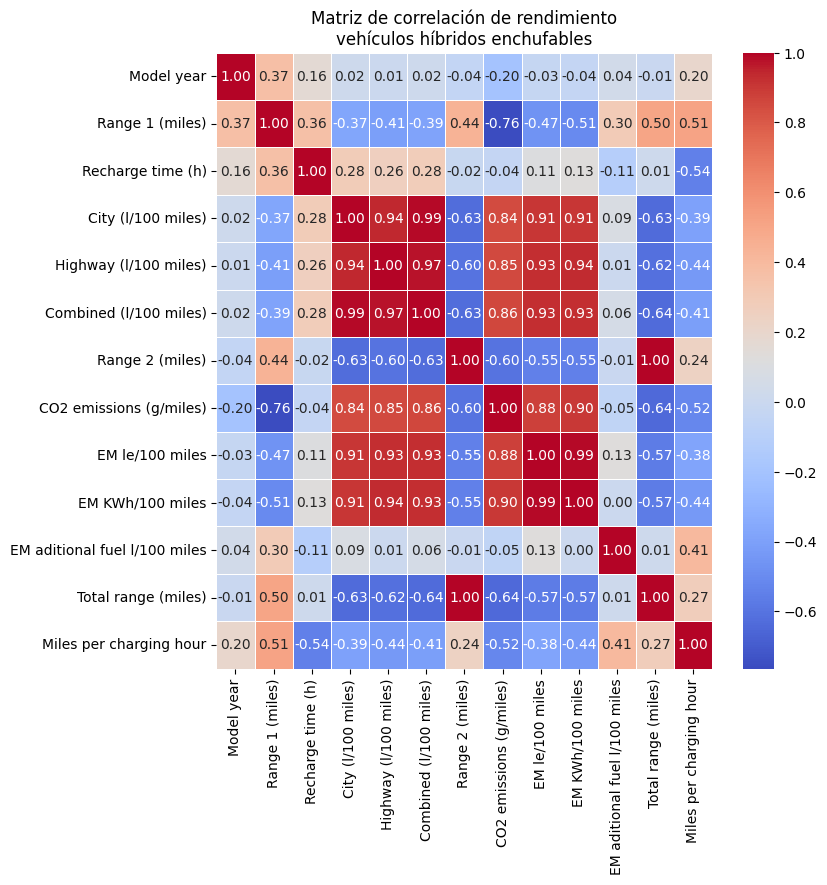

In [99]:
plt.figure(figsize=(8,8))
sns.heatmap(matriz, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de correlación de rendimiento\nvehículos híbridos enchufables')
plt.show()

# Conclusión preliminar

Luego de observar distintas características en cuanto al rendimiento de los híbridos enchufables, evaluamos que el Toyota Prius Prime podría ser una buena alternativa para implementar una flota de vehículos. Como se indica, es una conclusión preliminar, y esta opción podría modificarse al avanzar con el análisis.

In [100]:
nombres_normalizados = {'Model year':'model_year', 'Make':'make', 'Model':'model', 'Vehicle class':'vehicle_class',
                        'Range 1 (miles)':'range_1_(miles)', 'Recharge time (h)':'recharge_time_(h)', 'City (l/100 miles)':'city_(l/100_miles)',
                        'Highway (l/100 miles)':'highway_(l/100_miles)', 'Combined (l/100 miles)':'combined_(l/100_miles)',
                        'Range 2 (miles)':'range_2_(miles)', 'CO2 emissions (g/miles)':'co2(g/miles)', 'EM le/100 miles':'em_le/100_miles',
                        'EM KWh/100 miles':'em_kwh/100_miles', 'EM aditional fuel l/100 miles':'em_aditional_fuel_l/100_miles',
                        'Total range (miles)':'total_range_(miles)', 'Miles per charging hour':'miles_per_charging hour'}

In [101]:
df.rename(columns=nombres_normalizados, inplace=True)

In [102]:
df.to_csv(rendimiento_hibridos_limpio, sep=',', encoding='utf-8')